# In-depth explanation

> In-depth explanation of MonoDense layer

In [ ]:
# | hide
from os import environ
from pathlib import Path
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Input
from tensorflow.types.experimental import TensorLike

from airt.keras.layers import MonoDense
from airt._components.mono_dense_layer import (
    apply_monotonicity_indicator_to_kernel,
    get_activation_functions,
    get_monotonicity_indicator,
    replace_kernel_using_monotonicity_indicator,
)

In [ ]:
# | hide

environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

## Introduction

The simplest method to achieve monotonicity by construction
is to constrain the weights of the fully connected neural
network to have only non-negative (for non-decreasing variables)
or only non-positive values (for non-ascending) variables
when used in conjunction with a monotonic activation
function, a technique known for 30 years (Archer & Wang,
1993). When used in conjunction with saturated (bounded)
activation functions such as the sigmoid and hyperbolic tangent,
these models are difficult to train, i.e. they do not
converge to a good solution. On the other hand, when used
with non-saturated (unbounded) convex activation functions
such as ReLU (Nair & Hinton, 2010), the resulting models
are always convex (Liu et al., 2020), severely limiting the
applicability of the method in practice.


Our main contribution is a modification of the method above
which, in conjunction with non-saturated activation functions,
is capable of approximating non-convex functions
as well: when the original activation function is used with
additional two monotonic activation functions constructed
from it in a neural network with constrained weights, it can
approximate any monotone continuous functions.
The resulting model is guaranteed to be monotonic, can be
used in conjunction with popular convex monotonic nonsaturated
activation function, doesn’t have any additional
parameters compared to a non-monotonic fully-connected
network for the same task, and can be trained without any
additional requirements on the learning procedure. Experimental
results show it is exceeding the performance of all
other state-of-the-art methods, all while being both simpler
(in the number of parameters) and easier to train.
Our contributions can be summarized as follows:

1. A modification to an existing constrained neural network
layer enabling it to model arbitrary monotonic
function when used with non-saturated monotone convex
activation functions such as ReLU, ELU, SELU,
and alike.

2. Experimental comparisons with other recent works
showing that the proposed architecture can yield equal
or better results than the previous state-of-the-art and
with significantly fewer parameters.

3. A proof showing that the proposed architecture can
approximate any monotone continuous function on a
compact subset of $\mathbb{R}^n$ for a large class of non-saturated
activation functions.

## The problem

Most of the commonly used activation functions such as ReLU, ELU, SELU, etc. are monotonically increasing zero-centred, convex, lower-bounded non-polynomial functions. When used in a fully-connected, feed-forward neural network with at least one hidden layer and with unconstrained weights, they can approximate any continuous function on a compact subset. The simplest way to construct a monotonic neural network is to constrain its weights when used in conjunction with a monotone activation function. However, when the activation function is convex as well, the constrained neural network is not able to approximate non-convex functions. 


To better illustrate this, and to propose a simple solution in this particular example, we refer the readers to plots below where the goal is to approximate the simple cubic function $x^3$ using a neural network with a single hidden layer with either $2$ or $32$ neurons and with ReLU activation. A cubic function is apt for our illustration since it is concave in the considered interval $[-1, 0]$ and convex in the interval $[0, 1]$.

In [ ]:
# | hide


rng = np.random.default_rng(42)


def f(x):
    return x**3


def create_model(kind: str, units: int):
    x = Input(shape=(1,))
    y = x

    def get_layer(units, activation):
        if kind == "Constrained with ReLU-based activations":
            layer = MonoDense(units=units, activation=activation)
        elif kind == "Constrained ReLU":
            layer = MonoDense(units=units, is_convex=True, activation=activation)
        elif kind == "Unconstrained ReLU":
            layer = Dense(units, activation=activation)
        else:
            raise ValueError(kind)
        return layer

    y = get_layer(units=units, activation="relu")(y)
    y = get_layer(units=1, activation=None)(y)

    model = Model(inputs=x, outputs=y)
    return model


def train_model(model, *, batch_size=128, lr=0.003, epochs=10):
    x = np.arange(-1.1, 1.1, 0.0001)
    y = f(x)

    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        lr, decay_steps=len(x) // batch_size, decay_rate=0.9, staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=0)
    return model.evaluate(x, y, batch_size=256)

In [ ]:
# | hide

kinds = [
    "Unconstrained ReLU",
    "Constrained ReLU",
    "Constrained with ReLU-based activations",
]
models = {}
for kind in kinds:
    for units in [2, 32]:
        for seed in range(47, 100):
            print("*" * 120)
            print()
            print(f"{seed=}")
            print()
            tf.keras.utils.set_random_seed(seed)

            model = create_model(kind, units=units)
            model.summary()
            loss = train_model(model)
            if loss < 0.03:
                print(f"{kind=}, {units=}, {seed=}, {loss=}")
                models[(kind, units)] = model
                break

************************************************************************************************************************

seed=47

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 2)                 4         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
86/86 [==============================] - 0s 1ms/step - loss: 0.0035
kind='Unconstrained ReLU', units=2, seed=47, loss=0.00354481372050941
**************************************************************

In [ ]:
# | hide

# Set your custom color palette
colors = ["#E7338A", "#48A8D8", "#032545"]

three_color_palette = sns.color_palette(colors, 3)
print(f"{three_color_palette.as_hex()=}")
# sns.set_palette(three_color_palette, 3)
# sns.set_palette("colorblind", 3)


def plot_model(
    kind: str,
    linestyle="--",
    alpha=0.7,
    linewidth=5.0,
    save_image: bool = False,
    save_path: Union[Path, str] = "images",
    font_size: int = 11,
):
    plt.rcParams["figure.figsize"] = (5, 5)
    font = {"size": font_size}
    matplotlib.rc("font", **font)
    sns.set(font_scale=1.0)

    sns.set_palette(three_color_palette, 3)
    #     sns.set_palette("hls", 3)

    x = np.arange(-1.1, 1.1, 0.01)
    y = f(x)

    title = kind
    plt.title(title)

    plt.plot(
        x, y, label="ground truth", alpha=1.0, linewidth=linewidth * 0.5, linestyle="-"
    )

    for units, linestyle in zip([2, 32], ["--", ":"]):
        y = models[(kind, units)].predict(x)
        plt.plot(
            x,
            y,
            label=f"{units} neurons",
            alpha=alpha,
            linewidth=linewidth,
            linestyle=linestyle,
        )

    plt.axis("equal")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    plt.legend()

    if save_image:
        for file_format in ["pdf", "png"]:
            path = Path(save_path) / (title.replace(" ", "_") + f".{file_format}")
            path.parent.mkdir(exist_ok=True, parents=True)
            plt.savefig(path, format=file_format)
            print(f"Saved figure to: {path}")

    plt.show()

three_color_palette.as_hex()=['#e7338a', '#48a8d8', '#032545']


7/7 [==============================] - 0s 839us/step
Saved figure to: images/Unconstrained_ReLU.pdf
Saved figure to: images/Unconstrained_ReLU.png


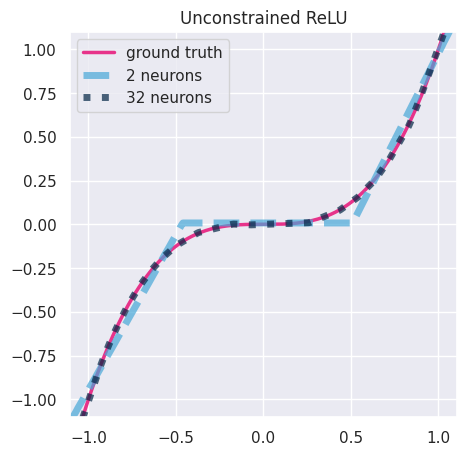

7/7 [==============================] - 0s 1ms/step
Saved figure to: images/Constrained_ReLU.pdf
Saved figure to: images/Constrained_ReLU.png


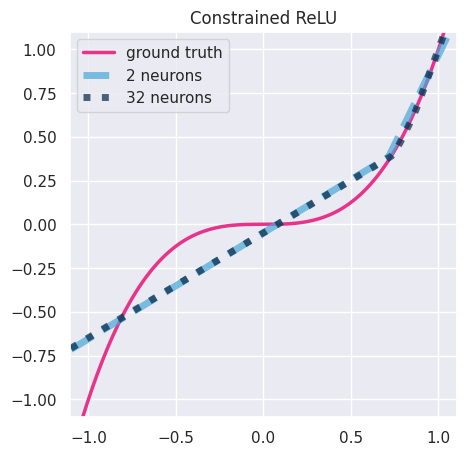

7/7 [==============================] - 0s 1ms/step
Saved figure to: images/Constrained_with_ReLU-based_activations.pdf
Saved figure to: images/Constrained_with_ReLU-based_activations.png


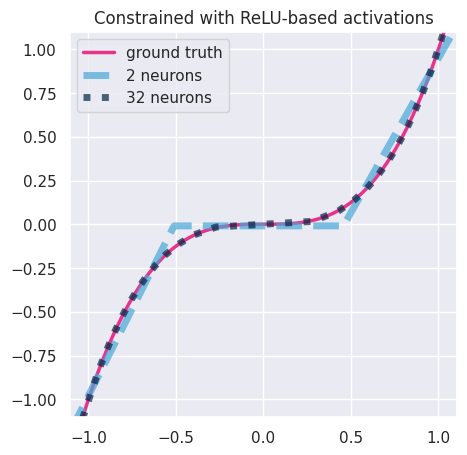

In [ ]:
# | hide

for kind in kinds:
    plot_model(kind, save_image=True)

<table>
    
<tr>
<td style="width:60%">

<img src="../../../images/nbs/images/Unconstrained_ReLU.png" alt="Unconstrained ReLU"/>
</td>
<td style="vertical-align:middle">

The plot to the left shows two fully-connected neural networks with one hidden layer with 2 and 32 neurons and ReLU activations approximating the qubic function on the interval $[-1, 1]$.
    
An unconstrained ReLU network with n neurons can approximate both concave and convex segments of the cubic function using at most $n + 1$ piecewise linear segments. Increasing the number of neurons will provide a better fit with the function being approximated. Notice that even though the cubic function is monotonic, there is no guarantee that the trained model will be monotonic as well.
    
</td>
</tr>
    
<tr>
<td>

<img src="../../../images/nbs/images/Constrained_ReLU.png" alt="Constrained ReLU"/>

    
</td>
<td style="vertical-align:middle">

If we constrain the weights of the network to be non-negative while still employing ReLU activation, the resulting model is monotone and convex. We can no longer approximate non-convex segments such as the cubic function on $[−1, 0]$ in the figure, and increasing the number of neurons from 2 to 32 does not yield any
significant improvement in the approximation.

</td>
</tr>
    
<tr>
<td>

<img src="../../../images/nbs/images/Constrained_with_ReLU-based_activations.png" alt="Constrained with ReLU-based activations"/>
    
</td>
<td style="vertical-align:middle">

Our proposed solution uses a combination of three activation functions in the hidden layer in order to gain the ability to model non-convex, monotone continuous functions. Notice that increasing the number of neurons increases the number of piecewise linear segments to approximate the cubic function. The resulting net-
work is monotone by construction even when trained on noisy data.

</td>
</tr>
    
    
</table>

### Activation Functions

Our construction is based on generating two additional activation functions from a typical non-saturated activation function such as ReLU, ELU and SELU.

We use $\breve{\mathcal{A}}$ to denote the set of all zero-centred, monotonically increasing, convex, lower-bounded functions. Let $\breve{\rho} \in \breve{\mathcal{A}}$. Then

$$
\hat{\rho}(x) = -\breve{\rho}(-x)
$$

$$
\tilde{\rho}(x) = \begin{cases}
      \breve{\rho}(x+1)-\breve{\rho}(1) & \text{if }x < 0\\
      \hat{\rho}(x-1)+\breve{\rho}(1) & \text{otherwise}
    \end{cases} 
$$

In [ ]:
# | hide


def plot_activation_functions(
    activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    *,
    font_size: int = 16,
    save_image: bool = False,
    save_path: Union[Path, str] = "images",
    alpha=0.7,
) -> None:
    font = {"size": font_size}
    #     sns.set_palette("hls", 3)
    sns.set_palette(three_color_palette, 3)
    matplotlib.rc("font", **font)
    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)
    plt.rcParams["figure.figsize"] = (10, 5)

    x = np.arange(-6.6, 6.6, 0.1)
    plt.plot(
        x,
        convex_activation(x),
        label=r"$\breve{\rho}(x)$",
        linestyle="-",
        linewidth=2.0,
        alpha=1.0,
    )
    plt.plot(
        x,
        concave_activation(x),
        label=r"$\hat{\rho}(x)$",
        linestyle="--",
        linewidth=4.0,
        alpha=0.7,
    )
    plt.plot(
        x,
        saturated_activation(x),
        label=r"$\tilde{\rho}(x)$",
        linestyle=":",
        linewidth=4.0,
        alpha=0.7,
    )
    plt.legend()

    title = f"{activation.__name__ if hasattr(activation, '__name__') else activation}-based activations"
    plt.title(title)
    plt.axis("equal")
    plt.xlim(-5.6, 5.6)
    plt.ylim(-3.2, 3.2)

    if save_image:
        for file_format in ["pdf", "png"]:
            path = Path(save_path) / (title.replace(" ", "_") + f".{file_format}")
            path.parent.mkdir(exist_ok=True, parents=True)
            plt.savefig(path, format=file_format)
            print(f"Saved figure to: {path}")

    plt.show()

Saved figure to: images/linear-based_activations.pdf
Saved figure to: images/linear-based_activations.png


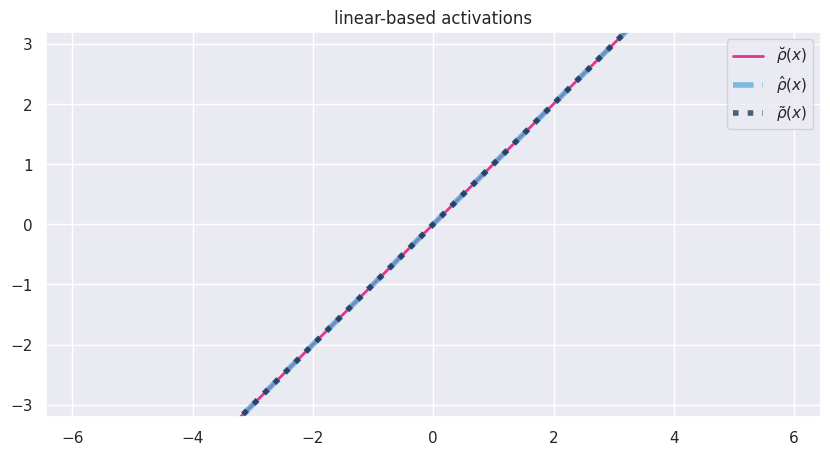

Saved figure to: images/ReLU-based_activations.pdf
Saved figure to: images/ReLU-based_activations.png


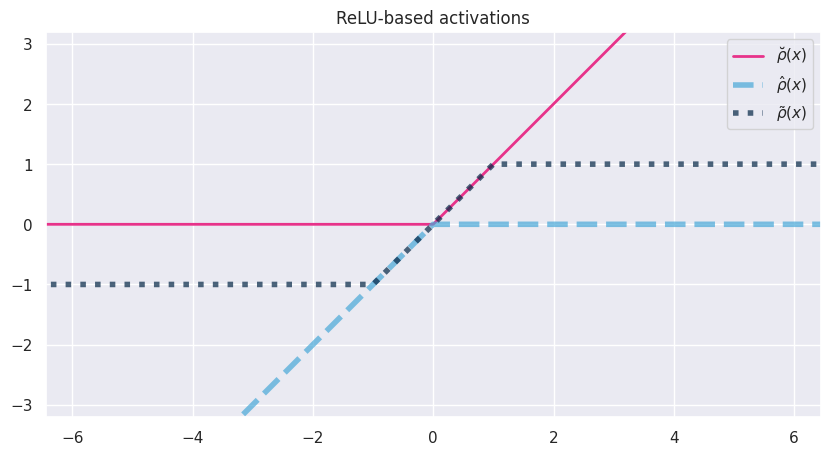

Saved figure to: images/ELU-based_activations.pdf
Saved figure to: images/ELU-based_activations.png


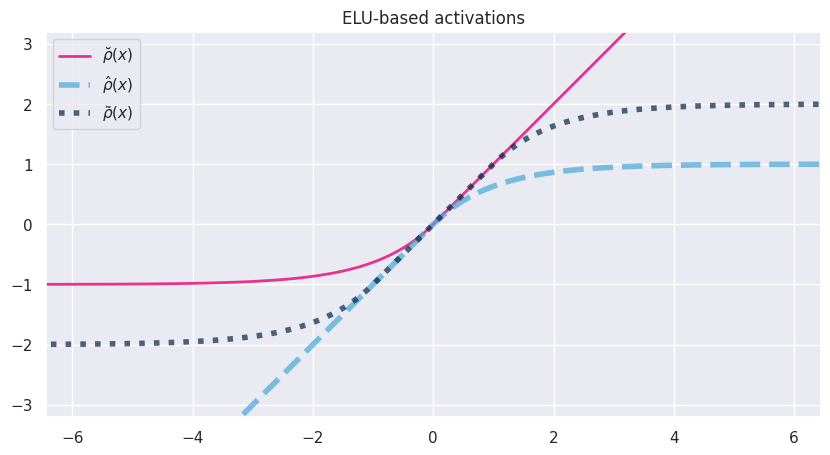

Saved figure to: images/SELU-based_activations.pdf
Saved figure to: images/SELU-based_activations.png


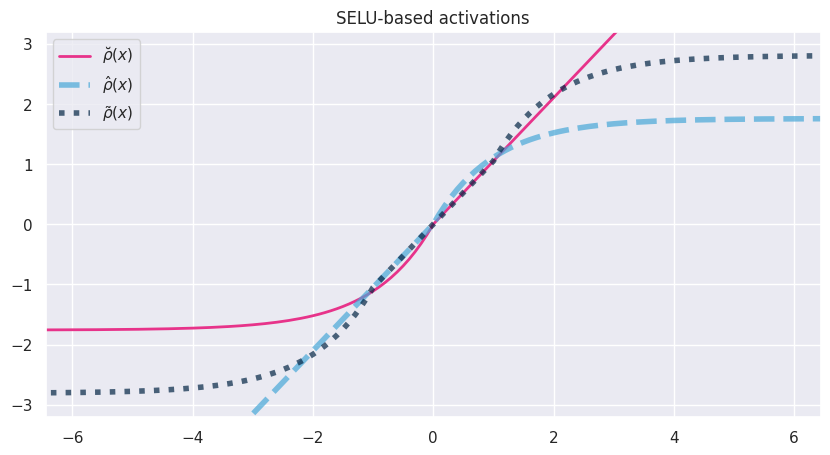

In [ ]:
# | hide


for activation in ["linear", "ReLU", "ELU", "SELU"]:
    plot_activation_functions(activation, save_image=True)

An example of such activation functions are given in figures below:

![ReLU-based_activations](images/ReLU-based_activations.png) ![ELU-based_activations](images/ELU-based_activations.png) 


### Monotonicity indicator


Our construction is preconditioned on a priori knowledge of (partial) monotonicity of a multivariate, multidimensional function $f$. Let $f: K \mapsto \mathbb{R}^m$ be defined on a compact segment $K \subseteq \mathbb{R}^n$. Then we define its $n$-dimensional *monotonicity indicator vector* $\mathbf{t} = [t_1, \dots, t_n]$ element-wise as follows:

$$
    t_j= \begin{cases}
      1 & \text{if }\cfrac{\partial f(\mathbf{x})_i} {\partial x_j} \geq 0 \ 
    \text{ for each } i \in \{1, \dots , m\}\\
      -1 & \text{if }\cfrac{\partial f(\mathbf{x})_i} {\partial x_j} \leq 0 \ 
    \text{ for each } i \in \{1, \dots , m\}\\
      0 & \text{otherwise}
    \end{cases} 
    \: 
$$

Given an $(m \times n)$-dimensional matrix $\mathbf{M}$ and $n$-dimensional monotonicity indicator vector $\mathbf{t}$, we define the operation $|.|_{t}$ assigning an $(m \times n)$-dimensional matrix $\mathbf{M'} = |\mathbf{M}|_{t}$ to $\mathbf{M}$ element-wise as follows:

$$
    m'_{j,i}= \begin{cases}
      |m_{j,i}| & \text{if }t_i=1\\
      -|m_{j,i}| & \text{if }t_i=-1\\
      m_{j,i} & \text{otherwise}
    \end{cases}
$$

In [ ]:
# | hide


def display_kernel(
    kernel: Union[tf.Variable, np.typing.NDArray[float]],
    *,
    title: str,
    save_path: Union[Path, str] = "images",
    save_image: bool = True,
) -> None:
    sns.set(font_scale=1.2)
    #     colors = ["#CC3238", "#032545"]
    #     colors = ["#032545", "#CC3238"]
    cm = sns.color_palette([colors[0], colors[1]], as_cmap=True)
    #     cm = sns.color_palette("vlag", as_cmap=True)
    cm = sns.diverging_palette(
        349.35825815417826, 233.30090815690622, s=85, l=55, as_cmap=True
    )
    plt.rcParams["figure.figsize"] = (10, 5)

    df = pd.DataFrame(kernel)

    #     display(
    #         df.style.format("{:.2f}").background_gradient(cmap=cm, vmin=-1e-8, vmax=1e-8)
    #     )

    ax = sns.heatmap(
        df,
        annot=True,
        cmap=cm,
        center=0.0,
        vmin=-0.01,
        vmax=0.01,
        fmt=".1f",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
    )
    plt.title(title, loc="left")

    if save_image:
        for file_format in ["pdf", "png"]:
            for s in [" ", "\n ", "$", "{", "}", "\\", "^"]:
                title = title.replace(s, "_")
            title = title.replace("×", "x")

            path = Path(save_path) / f"{title}.{file_format}"
            path.parent.mkdir(exist_ok=True, parents=True)
            plt.savefig(path, format=file_format)
            print(f"Saved figure to: {path}")

    plt.show()

Saved figure to: images/kernel__W__in__mathbb_R___9_x_12__.pdf
Saved figure to: images/kernel__W__in__mathbb_R___9_x_12__.png


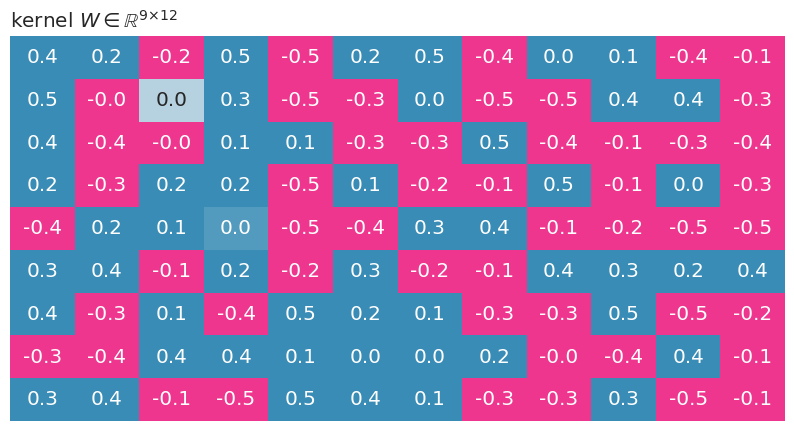

In [ ]:
# | hide

tf.keras.utils.set_random_seed(42)

units = 12
input_len = 9

layer = tf.keras.layers.Dense(units=units)

input_shape = (input_len,)
layer.build(input_shape=input_shape)

# print("Original kernel:")
rr = "\mathbb{R}^{9 × 12}"
# e =
display_kernel(layer.kernel, title=f"kernel $W \in {rr}$")

Saved figure to: images/kernel__(|W_T|_t)_T__after_applying_monotonicity_indicator__t=(-1,_-1,_-1,_0,_0,_0,_1,_1,_1)_.pdf
Saved figure to: images/kernel__(|W_T|_t)_T__after_applying_monotonicity_indicator__t=(-1,_-1,_-1,_0,_0,_0,_1,_1,_1)_.png


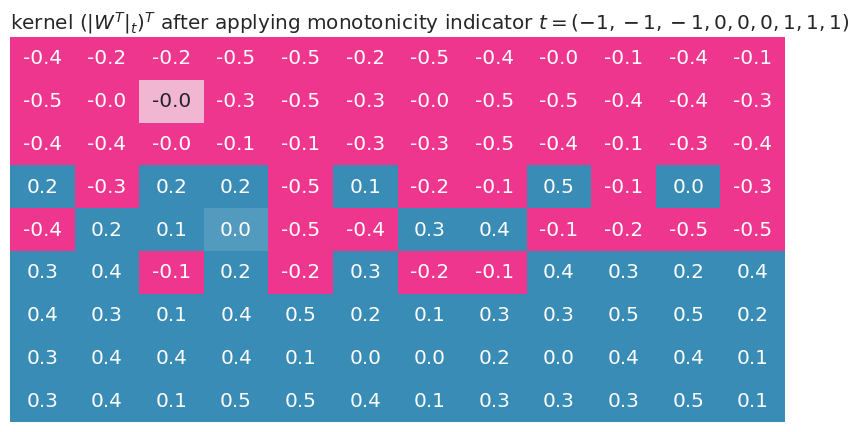

In [ ]:
# | hide

monotonicity_indicator = (
    [-1] * (input_len // 3)
    + [0] * (input_len - 2 * (input_len // 3))
    + [1] * (input_len // 3)
)

with replace_kernel_using_monotonicity_indicator(
    layer,
    get_monotonicity_indicator(
        monotonicity_indicator, input_shape=input_shape, units=units
    ),
):
    wt = "$(|W^T|_t)^T$"
    title = f"kernel {wt} after applying monotonicity indicator $t={tuple(monotonicity_indicator)}$"
    display_kernel(layer.kernel, title=title)

Below is an example of a kernel $W\in \mathbb{R}^{9 × 12}$ with 12 units and 9 inputs before and after applying the monotonicity indicator $t =(-1, -1, -1, 0, 0, 0, 1, 1, 1)$:

![original kernel](images/kernel__W__in__mathbb_R___9_x_12__.png)
![replaced kernel](images/kernel__(|W_T|_t)_T__after_applying_monotonicity_indicator__t=(-1,_-1,_-1,_0,_0,_0,_1,_1,_1)_.png)

### Monotonic Dense Layer

Monotonic Dense Unit (`MonoDense` class) uses weight constrains and activation functions constructed as explained above to construct partially monotonic neural networks. The below is the figure from the paper for reference.

In the constructor of `MonoDense` class:

- the parameter `monotonicity_indicator` corresponds to **t** in the figure below, and

- parameters `is_convex`, `is_concave` and `activation_weights` are used to calculate the activation selector **s** as follows:

    - if `is_convex` or `is_concave` is **True**, then the activation selector **s** will be (`units`, 0, 0) and (0, `units`, 0), respecively.

    - if both  `is_convex` or `is_concave` is **False**, then the `activation_weights` represent ratios between $\breve{s}$, $\hat{s}$ and $\tilde{s}$, respecively. E.g. if `activation_weights = (2, 2, 1)` and `units = 10`, then
    
$$
(\breve{s}, \hat{s}, \tilde{s}) = (4, 4, 2)
$$

![mono-dense-layer-diagram.png](images/mono-dense-layer-diagram.png)

Saved figure to: images/input__x__in__mathbb_R___9_x_12___with_batch_size_9_and_12_inputs.pdf
Saved figure to: images/input__x__in__mathbb_R___9_x_12___with_batch_size_9_and_12_inputs.png


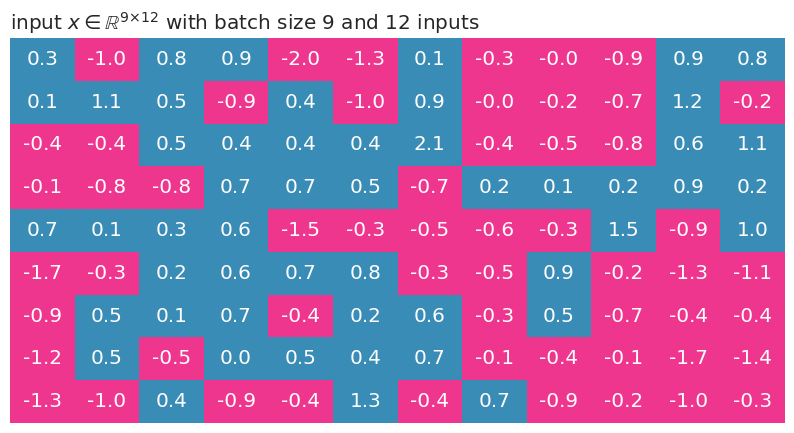

Saved figure to: images/kernel__(|W_T|_t)_T__in__mathbb_R___12_x_18___after_applying__t=[1,_1,_1,_1,_0,_0,_0,_0,_-1,_-1,_-1,_-1]__in__mathbb_R___12__.pdf
Saved figure to: images/kernel__(|W_T|_t)_T__in__mathbb_R___12_x_18___after_applying__t=[1,_1,_1,_1,_0,_0,_0,_0,_-1,_-1,_-1,_-1]__in__mathbb_R___12__.png


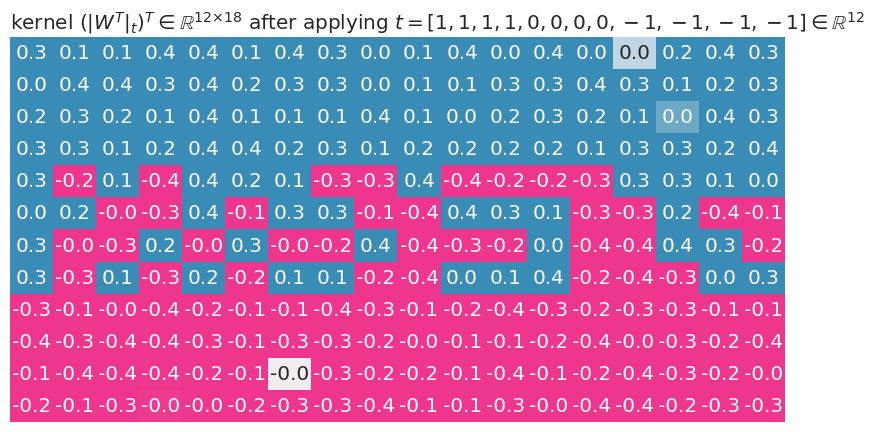

Saved figure to: images/batched_output__y__in__mathbb_R___9_x_18__.pdf
Saved figure to: images/batched_output__y__in__mathbb_R___9_x_18__.png


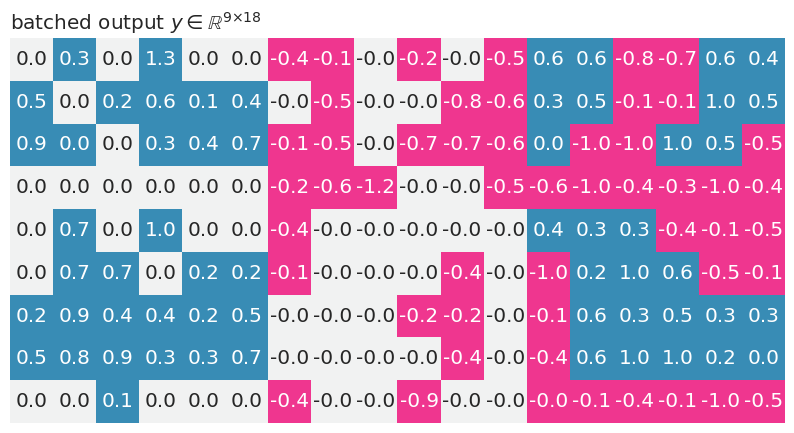

In [ ]:
# | hide

units = 18
activation = "relu"
batch_size = 9
x_len = 12

x = np.random.default_rng(42).normal(size=(batch_size, x_len))

tf.keras.utils.set_random_seed(42)

monotonicity_indicator = [1] * 4 + [0] * 4 + [-1] * 4

mono_layer = MonoDense(
    units=units,
    activation=activation,
    monotonicity_indicator=monotonicity_indicator,
    activation_weights=(6, 6, 6),
)
display_kernel(
    x, title="input $x \in \mathbb{R}^{9 × 12}$ with batch size 9 and 12 inputs"
)

y = mono_layer(x)
# print(f"monotonicity_indicator = {monotonicity_indicator}")
# display_kernel(mono_layer.monotonicity_indicator, title="monotonicity_indicator")

with replace_kernel_using_monotonicity_indicator(
    mono_layer, mono_layer.monotonicity_indicator
):
    ww = "\in \mathbb{R}^{12 × 18}"
    tt = "\in \mathbb{R}^{12}"
    display_kernel(
        mono_layer.kernel,
        title=f"kernel $(|W^T|_t)^T {ww}$ after applying $t={monotonicity_indicator} {tt}$",
    )

display_kernel(y, title="batched output $y \in \mathbb{R}^{9 × 18}$")

Bellow is an example of a batched input to `MoneDense` layer with batch size 9 and 12 inputs features.

![](images/input__x__in__mathbb_R___9_×_12___with_batch_size_9_and_12_inputs.png)

The figure below is an example of a kernel with 18 units and 12 input features.

![kernel](images/kernel__(|W_T|_t)_T__in__mathbb_R___12_x_18___after_applying__t=[1,_1,_1,_1,_0,_0,_0,_0,_-1,_-1,_-1,_-1]__in__mathbb_R___12__.png)

The input $x$ is multiplied with kernel $(|W^T|_t)^T \in \mathbb{R}^{12 × 18}$ after applying monotonicity indicator $t \in \mathbb{R}^{12}$ to it and then the bias $b$ (initially set to 0) is added to it:

![output](images/batched_output__y__in__mathbb_R___9_x_18__.png)

## Architecture types

The main advantage of our proposed monotonic dense unit is its simplicity. We can build deep neural nets with different architectures by plugging in our monotonic dense blocks. We have two functions for building neural networks using `MonoDense` layer. 

### Type-1 architecture

The first example shown in the figure below corresponds to the standard MLP type of neural network architecture used in general, where each of the input features is concatenated to form one single input feature vector $\mathbf{x}$ and fed into the network, with the only difference being that instead of standard fully connected or dense layers, we employ monotonic dense units throughout. For the first (or input layer) layer, the indicator vector $\mathbf{t}$, is used to identify the monotonicity property of the input feature with respect to the output. Specifically, $\mathbf{t}$ is set to $1$ for those components in the input feature vector that are monotonically increasing and is set to $-1$ for those components that are monotonically decreasing and set to $0$ if the feature is non-monotonic. For the subsequent hidden layers, monotonic dense units with the indicator vector $\mathbf{t}$ always being set to $1$ are used in order to preserve monotonicity. Finally, depending on whether the problem at hand is a regression problem or a classification problem (or even a multi-task problem), an appropriate activation function (such as linear activation or sigmoid or softmax) to obtain the final output.

![type-1](images/type-1.png)


In [ ]:
inputs = {name: Input(name=name, shape=(1,)) for name in list("abcd")}

outputs = MonoDense.create_type_1(
    inputs=inputs,
    units=64,
    final_units=10,
    activation="elu",
    n_layers=3,
    final_activation="softmax",
    monotonicity_indicator=dict(a=1, b=0, c=-1, d=0),
    dropout=0.1,
)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 b (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 d (InputLayer)                 [(None, 1)]          0           []                               
                                                                                            

### Type-2 architecture

The figure below shows another example of a neural network architecture that can be built employing proposed monotonic dense blocks. The difference when compared to the architecture described above lies in the way input features are fed into the hidden layers of neural network architecture. Instead of concatenating the features directly, this architecture provides flexibility to employ any form of complex feature extractors for the non-monotonic features and use the extracted feature vectors as inputs. Another difference is that each monotonic input is passed through separate monotonic dense units. This provides an advantage since depending on whether the input is completely concave or convex or both, we can adjust the activation selection vector $\mathbf{s}$ appropriately along with an appropriate value for the indicator vector $\mathbf{t}$. Thus, each of the monotonic input features has a separate monotonic dense layer associated with it. Thus as the major difference to the above-mentioned architecture, we concatenate the feature vectors instead of concatenating the inputs directly. The subsequent parts of the network are similar to the architecture described above wherein for the rest of the hidden monotonic dense units, the indicator vector $\mathbf{t}$ is always set to $1$ to preserve monotonicity.

![type-2](images/type-2.png)

In [ ]:
inputs = {name: Input(name=name, shape=(1,)) for name in list("abcd")}
outputs = MonoDense.create_type_2(
    inputs,
    units=32,
    final_units=10,
    activation="elu",
    final_activation="softmax",
    n_layers=3,
    dropout=0.2,
    monotonicity_indicator=dict(a=1, b=0, c=-1, d=0),
    is_convex=dict(a=True, b=False, c=False, d=False),
)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 b (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 d (InputLayer)                 [(None, 1)]          0           []                               
                                                                                            